# Import libraries


In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image  # Import PIL to resize images
import shutil
import torch.nn.functional as F

# Useful for examining network
from torchsummary import summary


import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

#

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-3-ce28f167b492>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


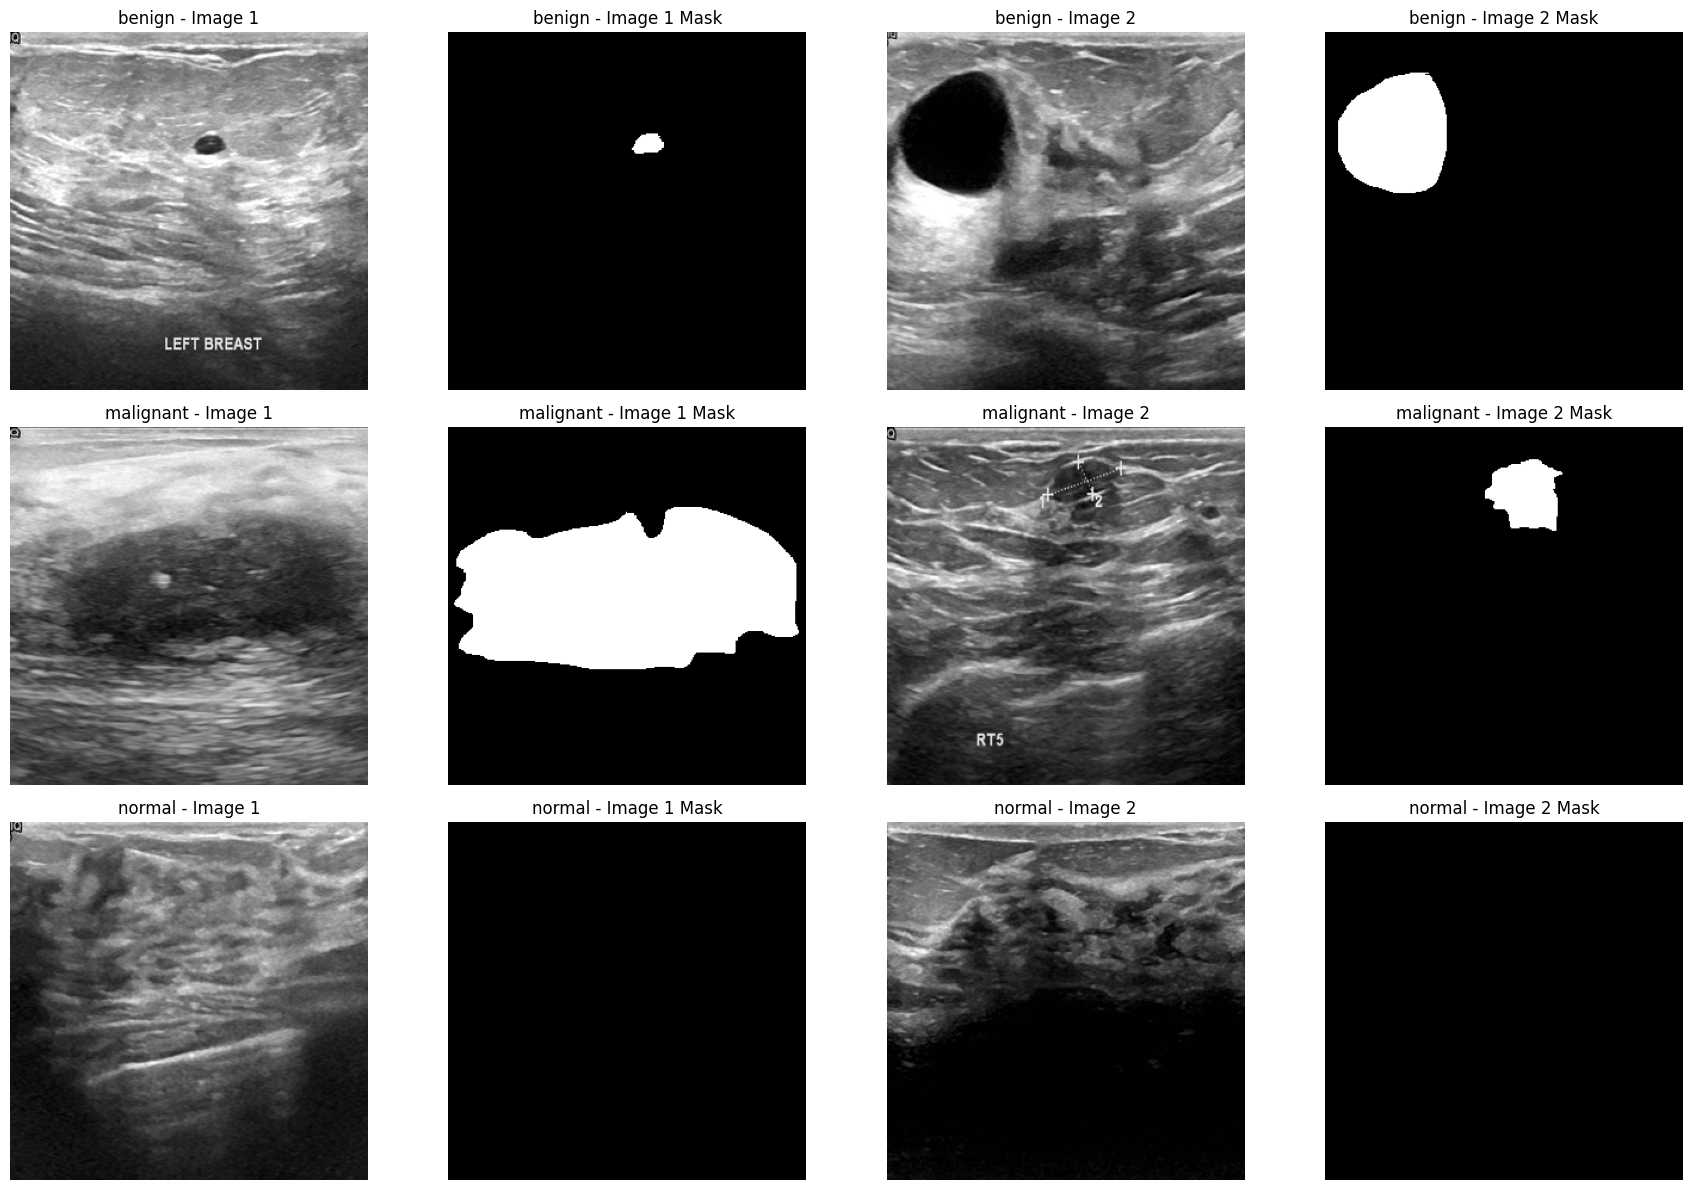

In [3]:
# Define the labels and corresponding directories
labels = ['benign', 'malignant', 'normal']
data_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /Dataset_BUSI_with_GT'

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)

    # Get a list of image files
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]

    # Sort the list of image files
    image_files = sorted(image_files)

    # Loop through the first 4 image files
    for j in range(4):
        if j < len(image_files):
            # Load and resize the image
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

            # Determine the label based on whether it's an image or a mask
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'

            # Display the image with the corresponding label
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [49]:
# Set the path to the Kaggle working directory
working_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("Working directory has been cleared.")

Working directory has been cleared.


# Defining Tranformation and Augmentation function

In [50]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
    'validation': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
}

# Data Split and create folders- excludes mask files

In [51]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Set the path to your input folder
data_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /Dataset_BUSI_with_GT'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

# Define the paths for the train, validation, and test directories
train_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/train'
val_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/validation'
test_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/test'

# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy the images to the corresponding directories
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

## Get the label counts after split - excludes mask files

In [52]:
import os
train_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/train'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

validation_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/validation'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")

test_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/test'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


## Display few images from each label - Only shows ultrasound images which will be used in our 1st approach

<ipython-input-53-2c52a93747a0>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


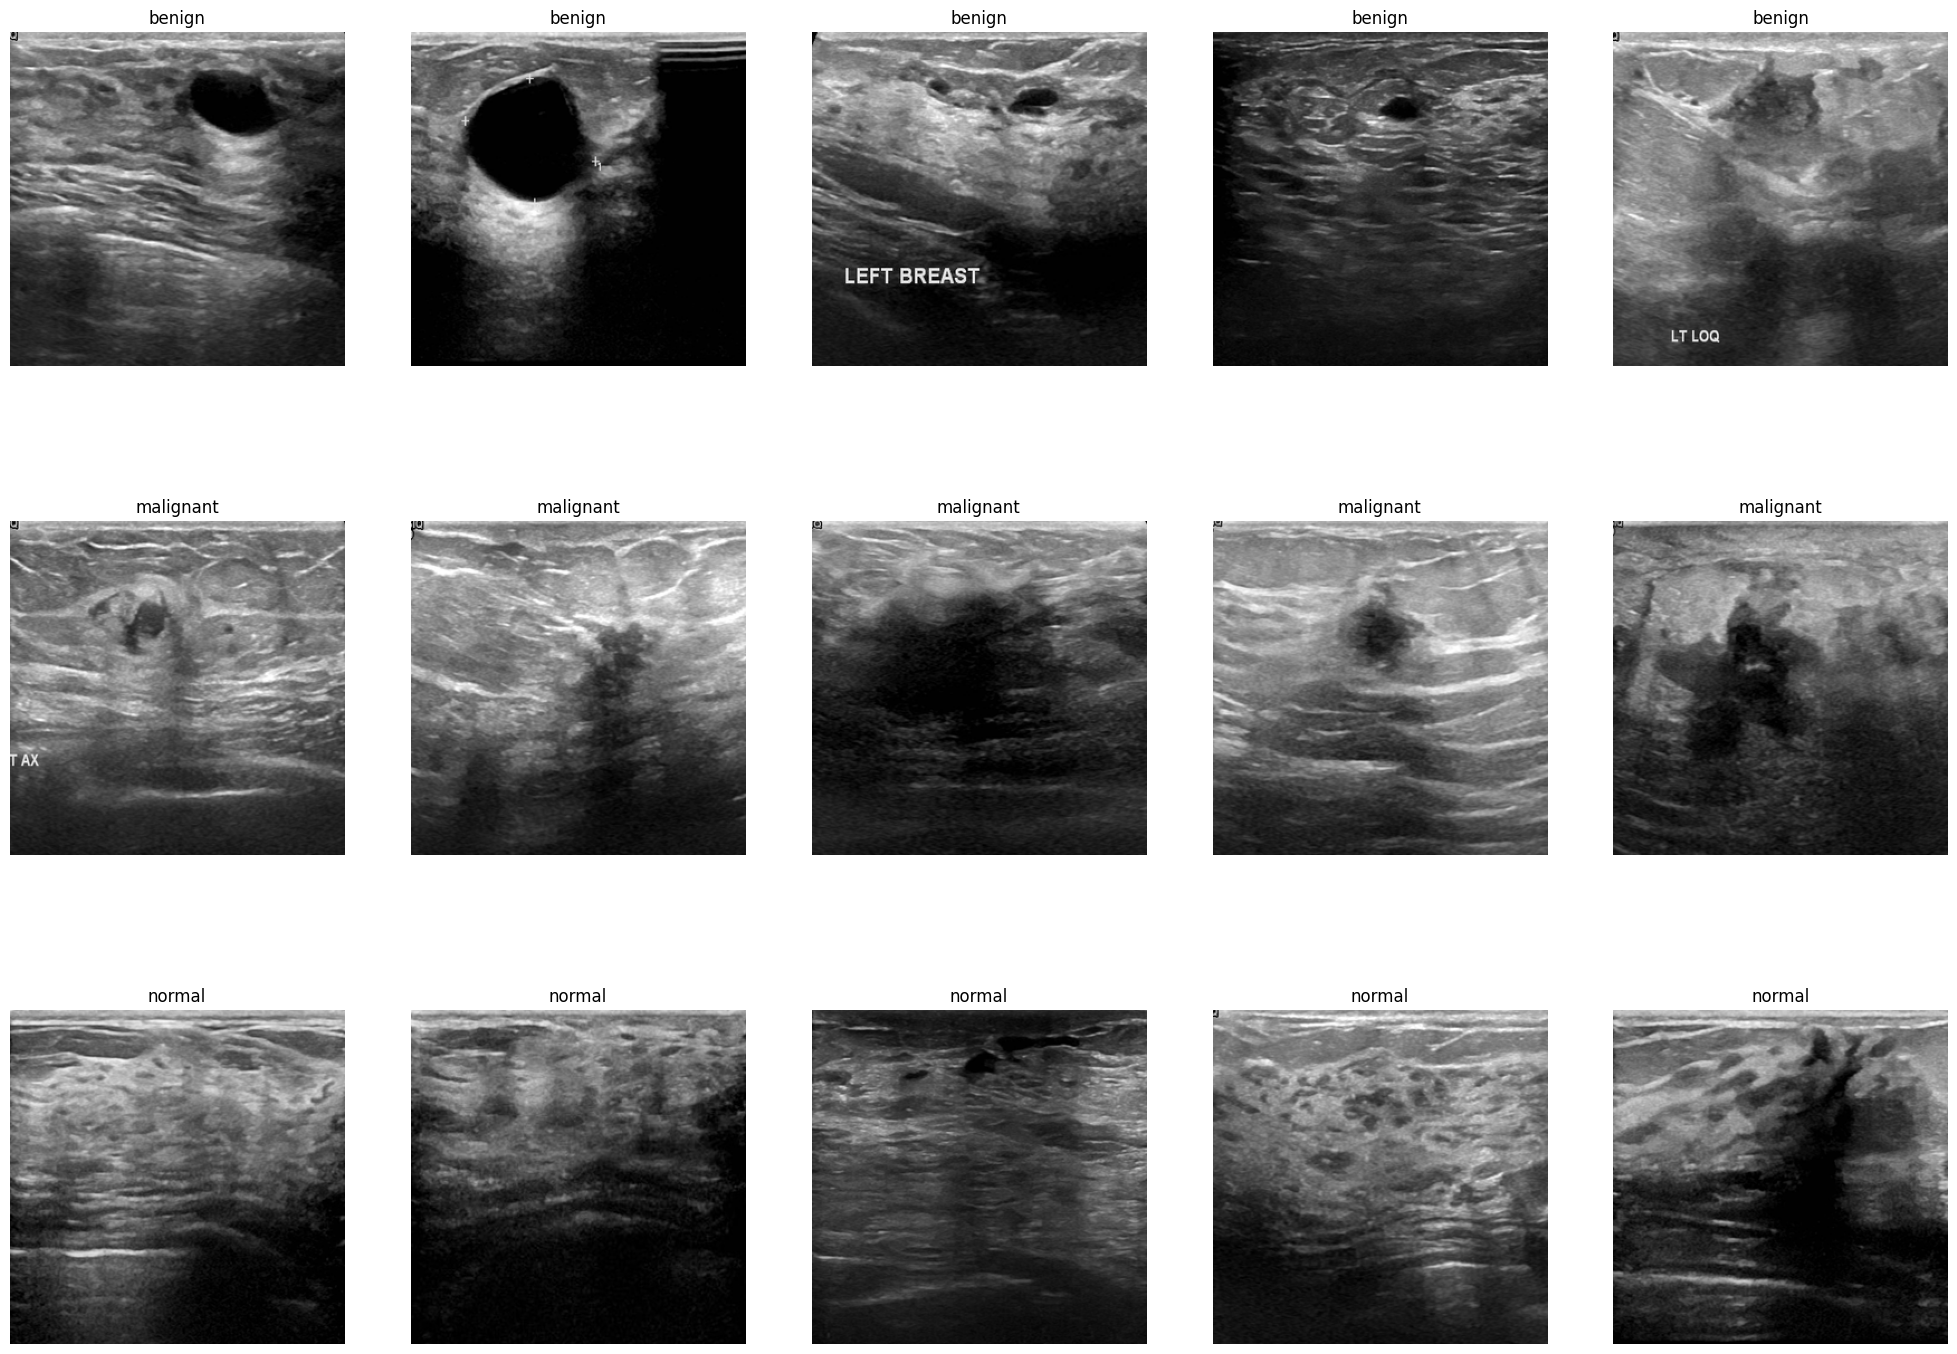

In [53]:
# Define the paths to the train directory
train_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/train'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(train_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 5, figsize=(25, 18))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

# Loop through each label and display 5 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files (excluding mask files)
    images = [image for image in os.listdir(label_dir) if not image.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(labels[i])
        axs[i, j].axis('off')

plt.show()

## Apply transfromation and augmentation to the datasets. Augmentation is only applied to the training data with extra focus on minority classes to balance the dataset. Calling the function that was defined earlier in the notebook.

In [54]:
data_dir='/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 8  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [55]:
test_dataloader = DataLoader(image_datasets['test'], batch_size=8, shuffle=True, num_workers=4)

In [56]:
img, target = next(iter(test_dataloader))
print(f"Image data type: {type(img)}")
print(f"     Image size: {img.shape}")

Image data type: <class 'torch.Tensor'>
     Image size: torch.Size([8, 1, 224, 224])


# Model

In [65]:
# Run test model to find input channel of fully connected layer (linear)

class Breast(torch.nn.Module):
    def __init__(self):
        super(Breast, self).__init__()
        # Convolutional Layer 1: 32 filter
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3)
        self.batchnorm1 = torch.nn.BatchNorm2d(32)

        self.pool = torch.nn.MaxPool2d(2, 2)

        # Convolutional Layer 2: 64 filter
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3)

        # Bỏ bớt 10% output từ filter layer trước
        self.drop1 = torch.nn.Dropout2d(0.1)
        self.batchnorm2 = torch.nn.BatchNorm2d(64)

        # Convolutional Layer 3: 64 filter
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3)
        self.batchnorm3 = torch.nn.BatchNorm2d(64)

        # Convolutional Layer 4: 128 filter
        self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=3)
        # Bỏ bớt 20% output từ filter layer trước
        self.drop2 = torch.nn.Dropout2d(0.2)
        self.batchnorm4 = torch.nn.BatchNorm2d(128)

        # Convolutional Layer 5: 256 filter
        self.conv5 = torch.nn.Conv2d(128, 256, kernel_size=3)
        self.batchnorm5 = torch.nn.BatchNorm2d(256)

        # Từ kết quả neuron phân bố 2D thành 1D
        self.flat = torch.nn.Flatten(start_dim=1, end_dim=-1)

        # self.fc1 = torch.nn.Linear(256*2*2, 128)
        self.fc1 = torch.nn.Linear(6400, 128)

        # Lớp cuối cùng cho ra kết quả phân loại
        self.fc2 = torch.nn.Linear(128, 3)

    def forward(self, x):
      # conv1
      x = self.batchnorm1(F.relu(self.conv1(x)))
      x = self.pool(x)

      # conv2
      x = self.batchnorm2(self.drop1(F.relu(self.conv2(x))))
      x = self.pool(x)

      # conv3
      x = self.batchnorm3(F.relu(self.conv3(x)))
      x = self.pool(x)

      # conv4
      x = self.batchnorm4(self.drop2(F.relu(self.conv4(x))))
      x = self.pool(x)

      # conv5
      x = self.batchnorm5(self.drop2(F.relu(self.conv5(x))))
      x = self.pool(x)

      # Fully connect
      x = self.flat(x)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

# device_name = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# modl = Breast().to(device_name)
# summary(modl, (1, 224, 224))



# Define training function

In [66]:
# Define the training function with early stopping and additional features
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Append training loss here
                if phase == 'train':
                    train_losses.append(loss.item())  # Append training loss
                else:
                    val_losses.append(loss.item())  # Append validation loss

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return model

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
model = Breast().to(device)

In [73]:
#Define optimzation algorithm
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

In [74]:
model_fineTuning = train_model_with_early_stopping(
    model, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2)
torch.save(model_fineTuning, "/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/Resnet_fineTuning.pth")

Epoch 0/19
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6411 Acc: 0.7229
validation Loss: 0.7020 Acc: 0.7200

Epoch 1/19
----------
train Loss: 0.6522 Acc: 0.7140
validation Loss: 0.8289 Acc: 0.6400

Epoch 2/19
----------
train Loss: 0.6356 Acc: 0.7318
validation Loss: 0.7294 Acc: 0.7200
Early stopping after 2 epochs
Training complete in 0m 26s
Best val Loss: 0.7020
              precision    recall  f1-score   support

      benign       0.79      0.82      0.81        56
   malignant       0.71      0.63      0.67        27
      normal       0.50      0.53      0.51        17

    accuracy                           0.72       100
   macro avg       0.67      0.66      0.66       100
weighted avg       0.72      0.72      0.72       100

Confusion Matrix:
[[46  5  5]
 [ 6 17  4]
 [ 6  2  9]]


# Model evaluation

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


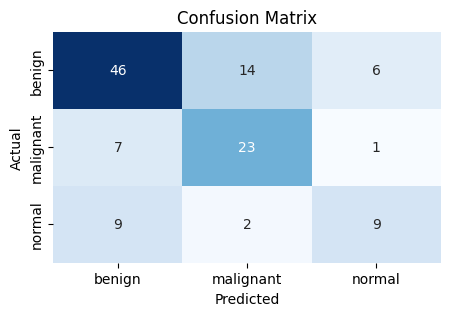

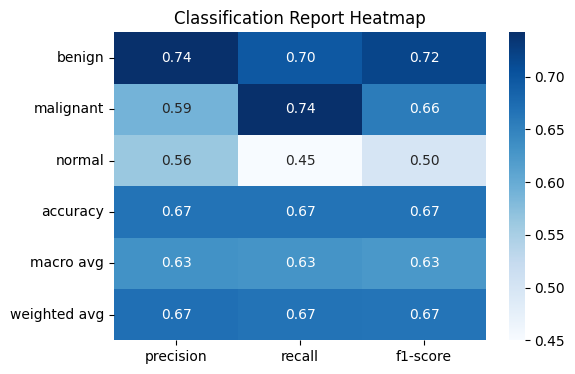

Simplified Classification Report:
             benign  malignant  normal  accuracy  macro avg  weighted avg
precision  0.741935   0.589744  0.5625  0.666667   0.631393      0.670938
recall     0.696970   0.741935  0.4500  0.666667   0.629635      0.666667
f1-score   0.718750   0.657143  0.5000  0.666667   0.625298      0.665034


In [75]:
# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

model_fineTuning.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])

## Visualizing results on few samples- Actual vs Prediction

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 1])


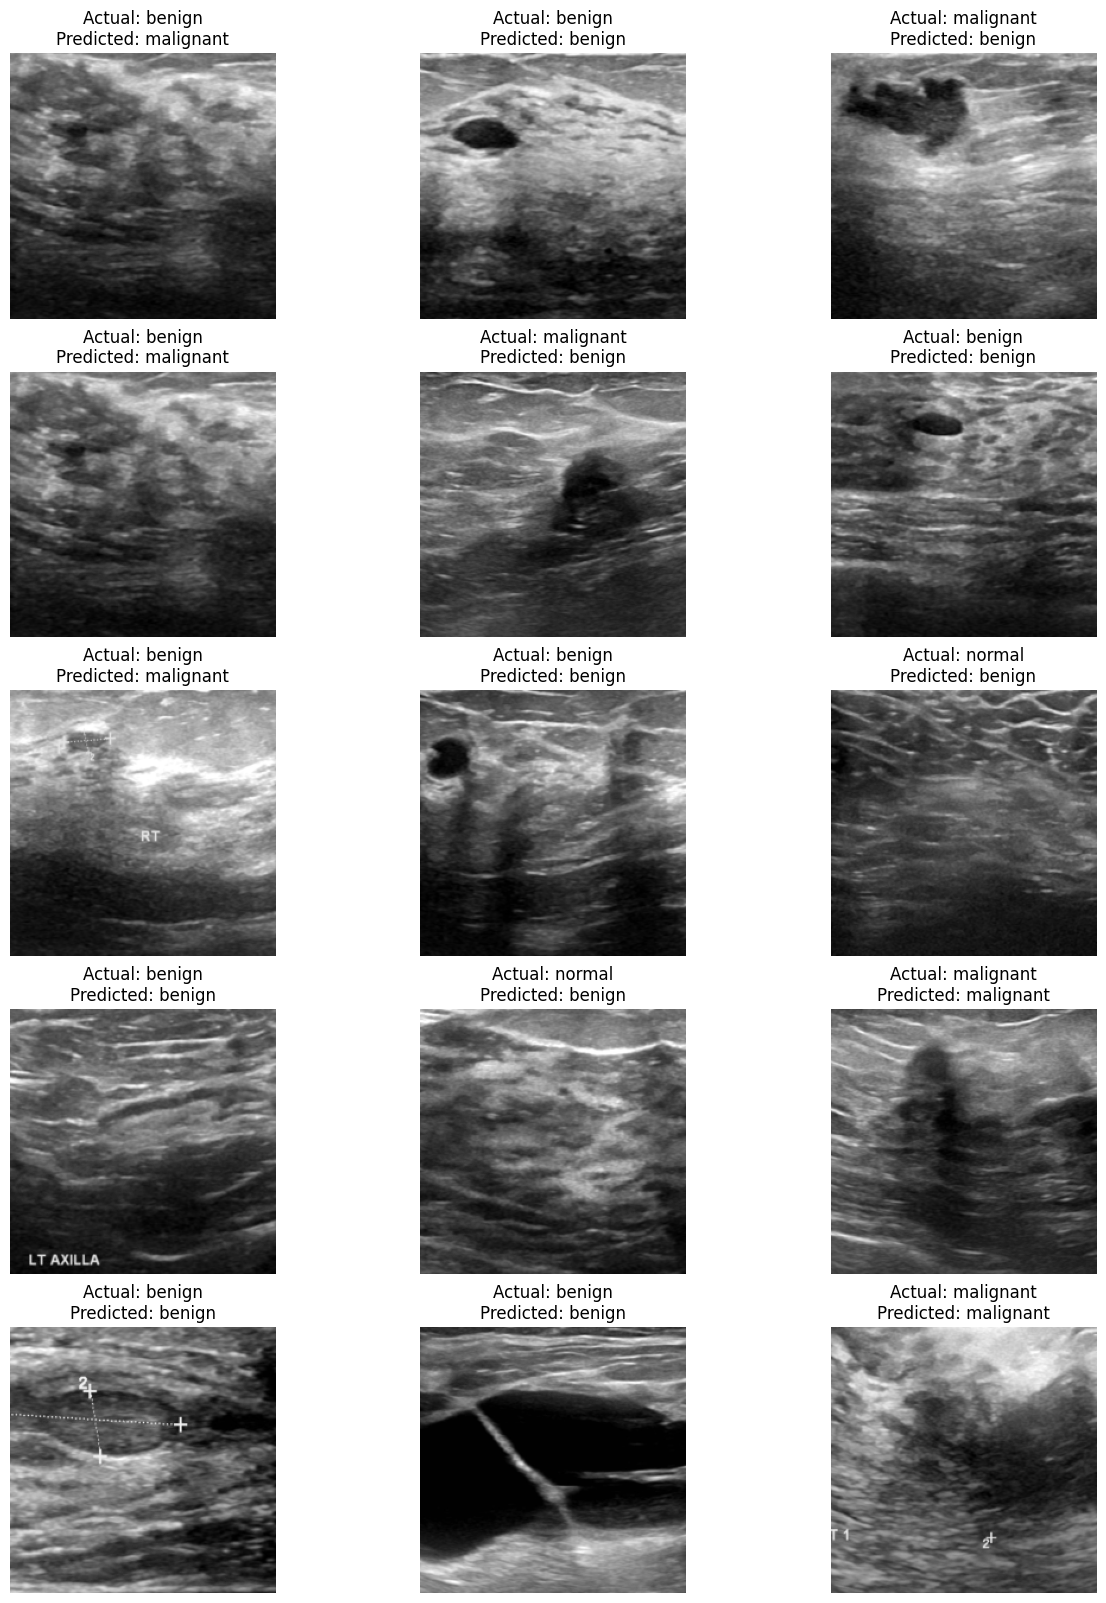

In [76]:
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /Dataset_BUSI_with_GT'

# Set the number of images to display
num_images_to_display = 15
test_dataset = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/test'

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)


inputs, labels = next(iter(test_dataloader))
print(labels)

# Move inputs to the device
inputs = inputs.to(device)

# Convert images to grayscale
grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

# Get model predictions
with torch.no_grad():
    model_fineTuning.eval()
    outputs = model_fineTuning(inputs)
    _, preds = torch.max(outputs, 1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()

# Prediction

In [31]:
img_benign = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/test/benign/benign (4).png'

In [32]:
img_malignant = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/train/malignant/malignant (179).png'

In [33]:
img_normal = '/content/drive/MyDrive/VNUK/data analytics for life science/Final /working/test/normal/normal (101).png'

In [80]:
def predict_img_class(img, model):
    class_names = ['benign', 'malignant','normal',]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    image = Image.open(img)

    #convert image to tensor
    img = transforms.Grayscale(num_output_channels=1)(image)
    img = transforms.Resize(256)(img)
    img = transforms.CenterCrop(224)(img)
    img = transforms.ToTensor()(img)
    img = transforms.Normalize([0.485], [0.229])(img)
    img = img.to(device)

    # Add an extra dimension and move the tensor back to the original device
    img = img.unsqueeze(0)

    print(img.shape)

    with torch.no_grad():
      model.eval()
      outputs = model(img)
      _, preds = torch.max(outputs, 1)
    return class_names[preds.item()]

predict_img_class(img_normal, model_fineTuning)

torch.Size([1, 1, 224, 224])


'normal'